# **Anomaly Detection on Dutch Facility Power Demand Dataset**

Dataset: 

Power Demand Dataset
http://www.cs.ucr.edu/~eamonn/discords/

Papers:

https://drive.google.com/file/d/1khXCdwU9Iyx6nPAtEZhaps1D3tdB27rS/view

https://drive.google.com/file/d/1WiwWDH5h-7KQVSmSCm8e0SZIKKZBCeDT/view

## Load Dataset

*The second dataset records power demand of a Dutch research facility for the
year 1997. The readings have been taken every 15 minutes, giving a total of 35040
observations. The data has a long weekly cycle of 672 time steps with five peaks
and two lows corresponding to high power consumption on weekdays and low power
consumption on weekends. The dataset has been used previously in and, where weekdays with a low power demand were considered anomalies. These
weekdays coincided with holidays. Similarly, weekends with a high power demand
can also be considered anomalies. We use the same approach.*

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import math
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read training files
dataset = pd.read_csv('/content/drive/My Drive/power_demand.txt', sep=" ", header=None)
dataset.columns = ['power_comsumption']
dataset['week'] = ""
dataset['weekend'] =""
dataset['day'] =""
dataset['label'] = ""

In [ ]:
cycle_count_in_a_day = int(60/15*24)
cycle_count_in_week = int(cycle_count_in_a_day*7)
total_week_count = int(math.ceil(35040/cycle_count_in_week))-2
cycles_for_weekdays = int(cycle_count_in_a_day*5)
cycles_for_weekends = int(cycle_count_in_a_day*2)
print("Cycle count for a day:", cycle_count_in_a_day)
print("Cycle count for one week:", cycle_count_in_week) 
print("Week count for dataset: ", total_week_count)
print("Cycles count weekdays/5 days: ", cycles_for_weekdays)
print("Cycles count weekends/2 days: ", cycles_for_weekends)

Cycle count for a day: 96
Cycle count for one week: 672
Week count for dataset:  51
Cycles count weekdays/5 days:  480
Cycles count weekends/2 days:  192


## Prepare Dataset

In [ ]:
def create_week_info_columns(dataset):
    week=1

    # delete weeks that are complete
    dataset=dataset[cycles_for_weekdays:-cycle_count_in_a_day*3]

    # for other weeks
    for i in range(0, len(dataset['power_comsumption']), 672):
        dataset['week'][i:i+672] = week
        dataset['weekend'][i:i+cycles_for_weekdays] = 0
        dataset['weekend'][i+cycles_for_weekdays:i+672] = 1
        for j in range(1,8):
            dataset['day'][i+cycle_count_in_a_day*(j-1):i+cycle_count_in_a_day*j] = j

        week = week +1
    return dataset

In [ ]:
def plot_cycles_for_weeks(dataset, week):
    plt.plot(dataset[(dataset['week']==week)&(dataset['weekend']==0)]['power_comsumption'], label="weekdays")
    plt.plot(dataset[(dataset['week']==week)&(dataset['weekend']==1)]['power_comsumption'], color='green', label="weekend")
    plt.xlabel('cycles (in every 15 min)')
    plt.ylabel('power consumption')
    plt.legend(loc="upper left")
    plt.title("Week " + str(week))
    plt.show()

In [ ]:
dataset = create_week_info_columns(dataset)

In [ ]:
print("Week 2 data: ")
dataset[cycle_count_in_a_day*5:cycle_count_in_a_day*5+cycle_count_in_week]

Week 2 data: 


,power_comsumption,week,weekend,day,label
960,1043,1,1,6,
961,1043,1,1,6,
962,1046,1,1,6,
963,1028,1,1,6,
964,1042,1,1,6,
...,...,...,...,...,...
1627,1050,2,0,5,
1628,1053,2,0,5,
1629,1073,2,0,5,
1630,1063,2,0,5,


In [ ]:
dataset.shape

(34272, 5)

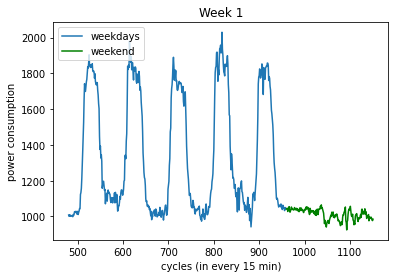

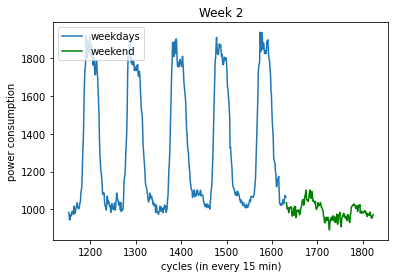

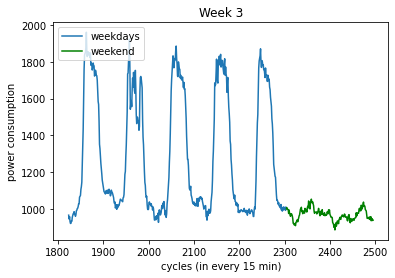

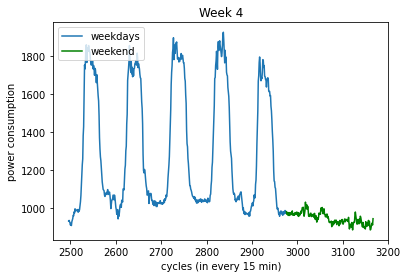

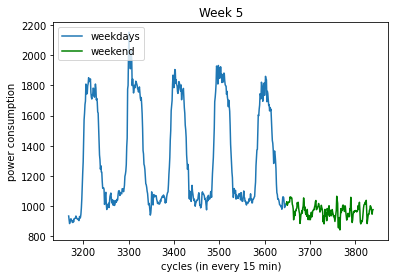

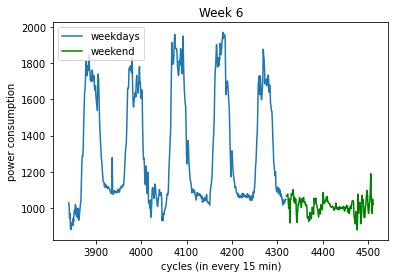

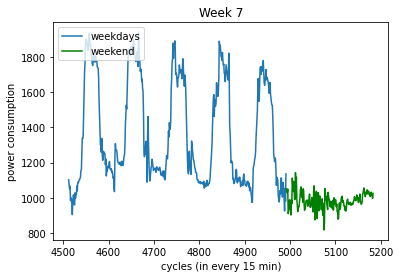

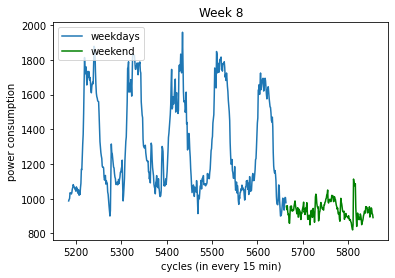

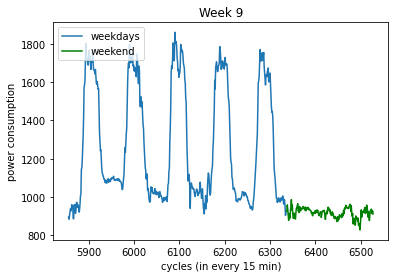

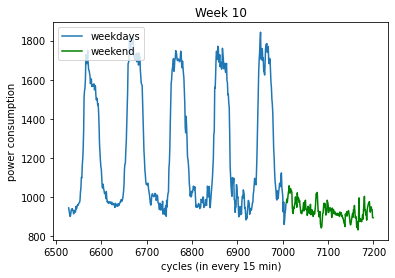

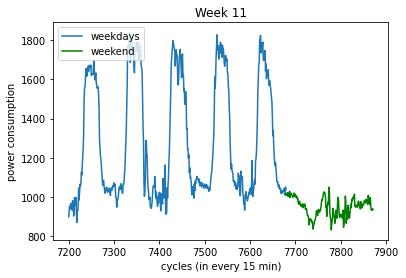

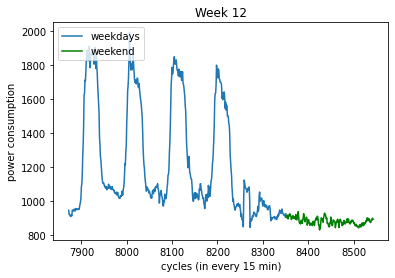

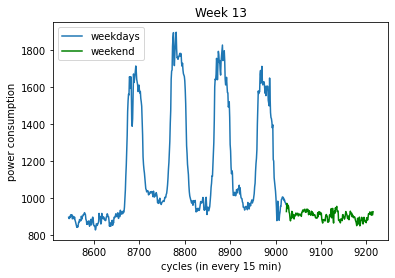

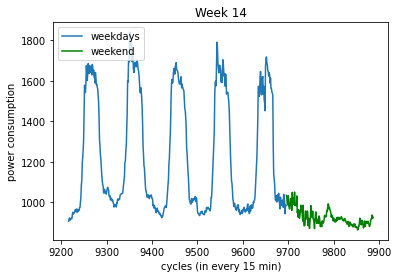

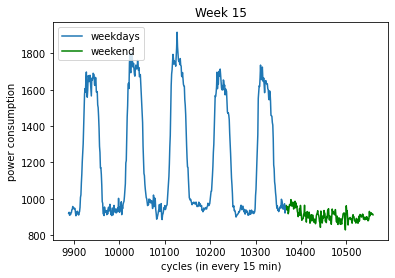

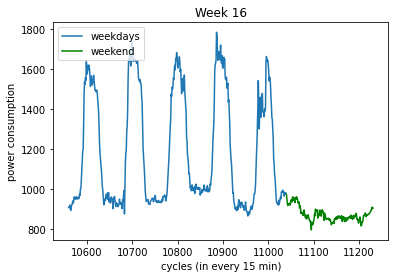

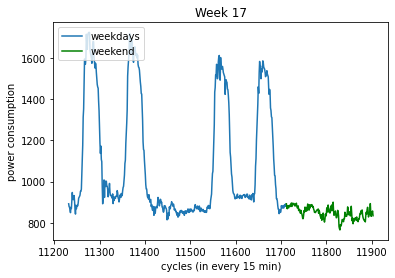

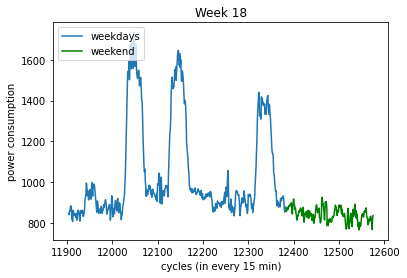

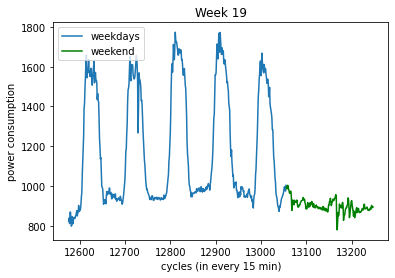

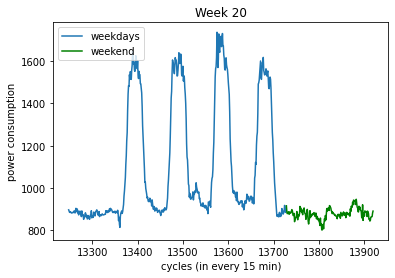

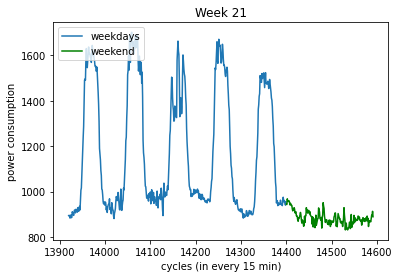

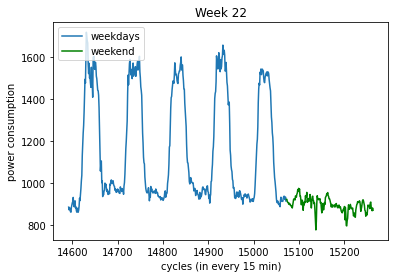

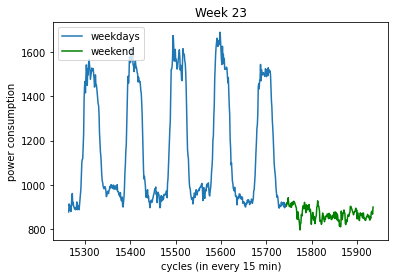

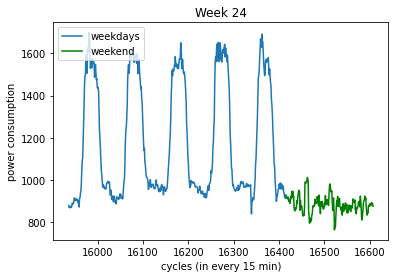

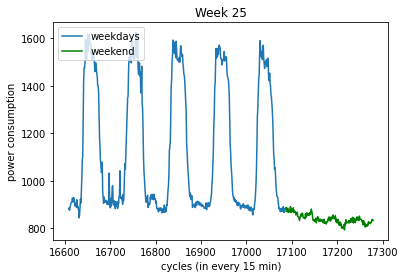

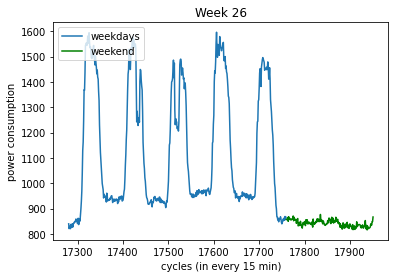

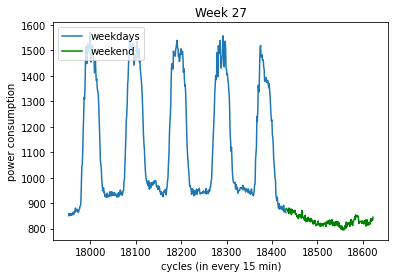

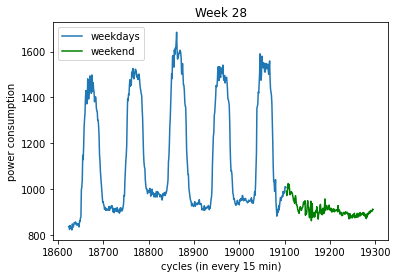

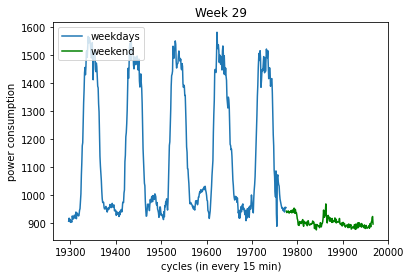

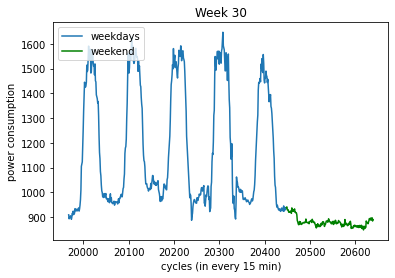

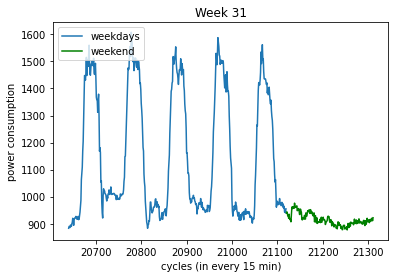

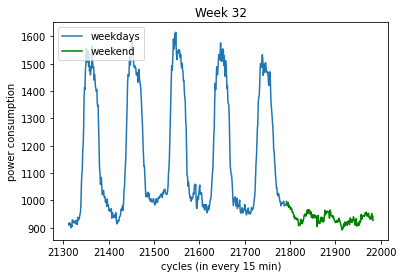

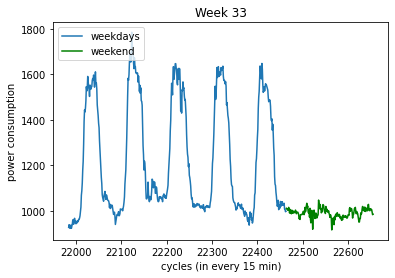

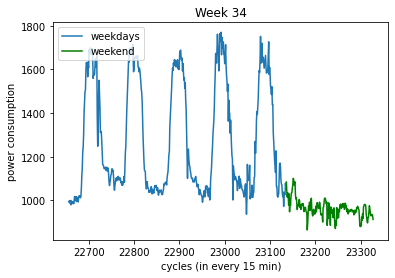

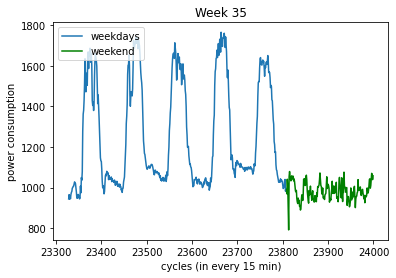

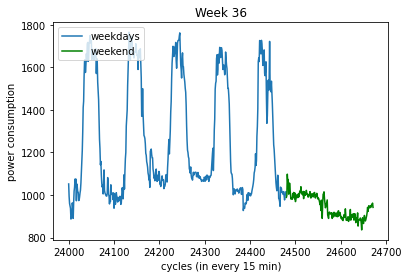

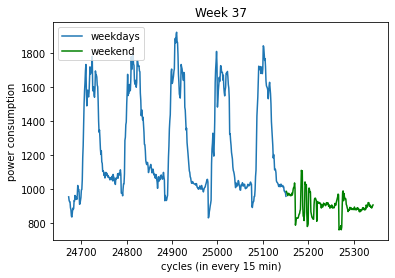

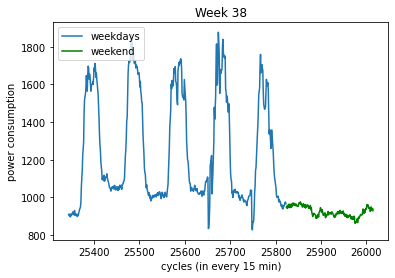

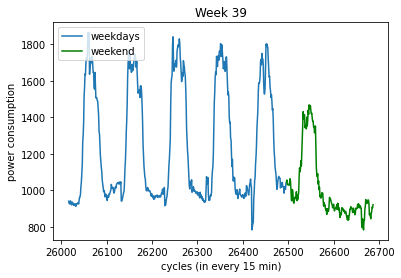

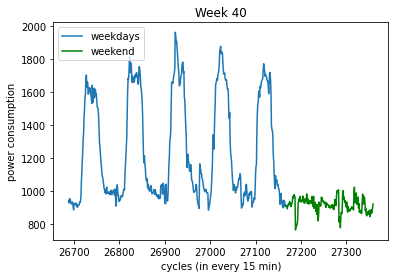

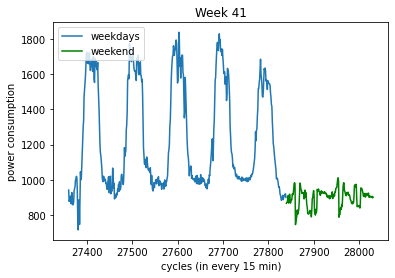

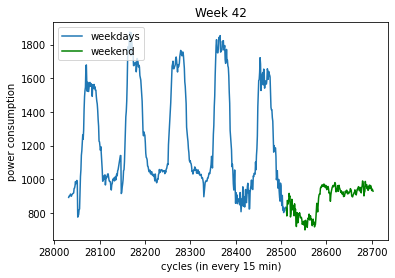

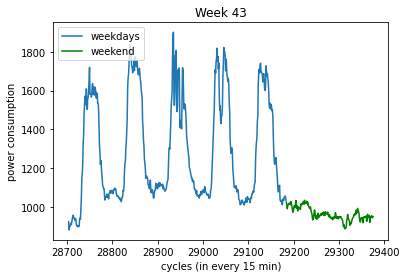

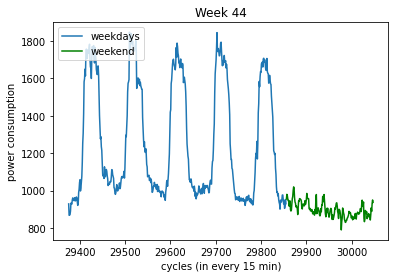

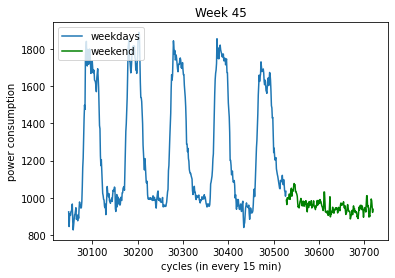

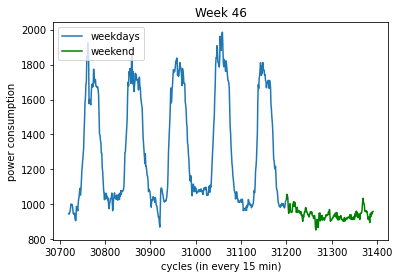

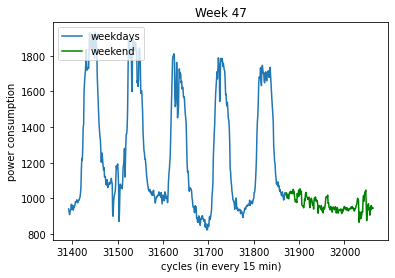

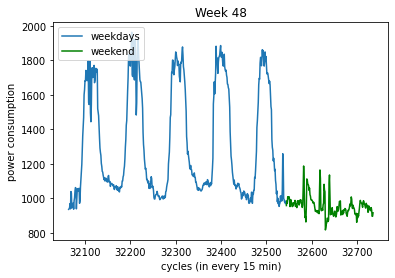

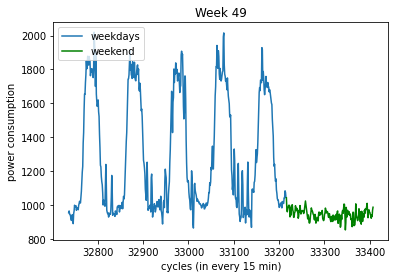

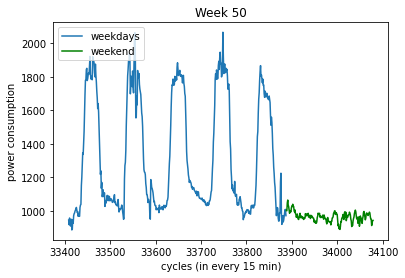

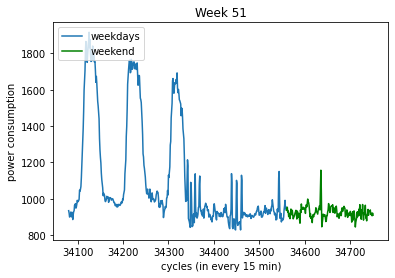

In [ ]:
for i in range (1, total_week_count+1):
    plot_cycles_for_weeks(dataset, i)

Fill label(anomaly) column

In [ ]:
anomalies = [(12,5), (13, 1), (17, 3), (18,1), (18,4), (20,1), (39,6), (42,6), (42,7), (51,4), (51,5)]

for week, day in anomalies:
    dataset.loc[((dataset["week"]==week)&(dataset["day"]==day)), 'label'] = 1
dataset.loc[dataset["label"]=="", 'label'] = 0

In [ ]:
dataset[dataset['label']==1]

,power_comsumption,week,weekend,day,label
8256,879,12,0,5,1
8257,846,12,0,5,1
8258,1030,12,0,5,1
8259,1122,12,0,5,1
8260,1104,12,0,5,1
...,...,...,...,...,...
34555,941,51,0,5,1
34556,960,51,0,5,1
34557,991,51,0,5,1
34558,943,51,0,5,1


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(dataset[['power_comsumption','weekend']])
dataset['power_comsumption'] = pca.transform(dataset[['power_comsumption','weekend']])

In [ ]:
dataset

,power_comsumption,week,weekend,day,label
480,-136.395676,1,0,1,0
481,-143.395675,1,0,1,0
482,-135.395677,1,0,1,0
483,-135.395677,1,0,1,0
484,-143.395675,1,0,1,0
...,...,...,...,...,...
34747,-224.396382,51,1,7,0
34748,-232.396380,51,1,7,0
34749,-238.396378,51,1,7,0
34750,-223.396382,51,1,7,0


## Split Dataset

*We
split the dataset into train and test sets with ratio 70:30, or
equivalently 37 weeks:15 weeks. The train set only contains
normal weeks and the test set contains the remaining normal
weeks and all the 8 anomalous weeks, each having at least
one abnormal day.*

In [ ]:
import random

In [ ]:
train_week_size = 37
test_week_size = 14

In [ ]:
def split_dataset(dataset):

    # add anomaly weeks to test data
    test_indexes = list(dataset[dataset['label']==1]['week'].unique())[:-3]
    # select remaning test indexes by random (test_indexes are blacklisted)
    choices = list(set(range(1, total_week_count)).difference(test_indexes))
    test_indexes.extend([random.choice(choices) for i in range(1, test_week_size - len(test_indexes) +1)])
    test_indexes.sort()
    print(test_indexes)
    # split dataset
    test_data = dataset.loc[dataset['week'].isin(test_indexes)]
    train_data = dataset.loc[~dataset['week'].isin(test_indexes)]

    return train_data, test_data

In [ ]:
train, test = split_dataset(dataset)

[4, 12, 13, 16, 17, 18, 20, 23, 26, 28, 45, 48, 48, 50]


In [ ]:
print(train[train['label']==1])

       power_comsumption week weekend day label
26496         -97.396416   39       1   6     1
26497         -87.396418   39       1   6     1
26498        -113.396411   39       1   6     1
26499        -110.396412   39       1   6     1
26500        -112.396412   39       1   6     1
...                  ...  ...     ...  ..   ...
34555        -203.395659   51       0   5     1
34556        -184.395664   51       0   5     1
34557        -153.395672   51       0   5     1
34558        -201.395659   51       0   5     1
34559        -190.395662   51       0   5     1

[480 rows x 5 columns]


In [ ]:
print(test[test['label']==1])

       power_comsumption week weekend day label
8256         -265.395642   12       0   5     1
8257         -298.395633   12       0   5     1
8258         -114.395682   12       0   5     1
8259          -22.395707   12       0   5     1
8260          -40.395702   12       0   5     1
...                  ...  ...     ...  ..   ...
13339        -253.395645   20       0   1     1
13340        -240.395649   20       0   1     1
13341        -244.395648   20       0   1     1
13342        -244.395648   20       0   1     1
13343        -248.395647   20       0   1     1

[576 rows x 5 columns]


## Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

In [ ]:
def reshape(dataset_np):
    x_reshaped=[]
    y_reshaped=[]
    for i in np.unique(dataset_np[:, 1]):
        temp_x = np.asarray([dataset_np[dataset_np[:, 1]==i][:,0]]).astype(np.float32)
        temp_y = np.asarray([dataset_np[dataset_np[:, 1]==i][:,-1]]).astype(np.float32)
        if x_reshaped==[]:
            x_reshaped = temp_x
            y_reshaped = np.asarray([1 if 1 in temp_y else 0])
        else:
            x_reshaped = np.concatenate((x_reshaped, temp_x), axis=0)
            y_reshaped = np.concatenate((y_reshaped, np.asarray([1 if 1 in temp_y else 0])), axis=0)
    y_reshaped = np.reshape(y_reshaped, (-2, 1))
    return x_reshaped, y_reshaped

In [ ]:
scaler = StandardScaler()
scaler.fit(train[['power_comsumption']].to_numpy())
train[['power_comsumption']] = scaler.transform(train[['power_comsumption']].to_numpy())
test[['power_comsumption']] = scaler.transform(test[['power_comsumption']].to_numpy())

In [ ]:
x_train_lstm, y_train_lstm = reshape(np.asarray(train))
print(x_train_lstm.shape)
print(y_train_lstm.shape)

x_test_lstm, y_test_lstm = reshape(np.asarray(test))
print(x_test_lstm.shape)
print(y_test_lstm.shape)

(38, 672)
(38, 1)
(13, 672)
(13, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


## Model

In [ ]:
from keras.models import Sequential
from keras.metrics import RootMeanSquaredError
import keras
from keras.layers import Dense, Conv1D, LSTM, SimpleRNN, Flatten, Dropout, Activation
from keras.initializers import glorot_uniform # Xavier normal initializer
from keras import backend as K
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
def plot_history(model, history):

    # summarize history for mse
    fig_mse = plt.figure(figsize=(5, 5))
    plt.plot(history.history['mse'])
    # plt.plot(history.history['val_mse'])
    plt.title('MSE')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_r2.png")

    # summarize history for acc
    fig_acc = plt.figure(figsize=(5, 5))
    plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_r2.png")

    # summarize history for loss
    fig_loss = plt.figure(figsize=(5, 5))
    plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    plt.title('Loos')
    plt.ylabel('Loos')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_rmse.png")

## LSTM

In [ ]:
x_train_lstm = x_train_lstm.reshape((x_train_lstm.shape[0],x_train_lstm.shape[1], 1))
x_test_lstm = x_test_lstm.reshape((x_test_lstm.shape[0],x_test_lstm.shape[1], 1))

y_train_lstm = y_train_lstm.reshape((y_train_lstm.shape[0], 1))
y_test_lstm = y_test_lstm.reshape((y_test_lstm.shape[0], 1))

print(x_train_lstm.shape)
print(y_train_lstm.shape)

print(x_test_lstm.shape)
print(y_test_lstm.shape)

(38, 672, 1)
(38, 1)
(13, 672, 1)
(13, 1)


In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(300, input_shape=(x_train_lstm.shape[1],1), return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Flatten())
model_lstm.add(Dense(1, activation='tanh'))
model_lstm.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 672, 300)          362400    
_________________________________________________________________
dropout_16 (Dropout)         (None, 672, 300)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 201600)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 201601    
Total params: 564,001
Trainable params: 564,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.01)
model_lstm.compile(optimizer=adam, loss= 'binary_crossentropy', metrics=['mse','accuracy'])

In [ ]:
history_lstm = model_lstm.fit(x_train_lstm, y_train_lstm, epochs=25)
print(history_lstm.history.keys())

Epoch 1/25
2/2 [==============================] - 1s 667ms/step - loss: 2.6511 - mse: 0.2274 - accuracy: 0.7632
Epoch 2/25
2/2 [==============================] - 1s 639ms/step - loss: 14.0454 - mse: 0.9211 - accuracy: 0.0789
Epoch 3/25
2/2 [==============================] - 1s 573ms/step - loss: 8.4819 - mse: 1.0083 - accuracy: 0.4211
Epoch 4/25
2/2 [==============================] - 1s 623ms/step - loss: 14.0454 - mse: 0.9211 - accuracy: 0.0789
Epoch 5/25
2/2 [==============================] - 1s 634ms/step - loss: 13.2428 - mse: 0.9211 - accuracy: 0.1316
Epoch 6/25
2/2 [==============================] - 1s 614ms/step - loss: 8.8285 - mse: 0.9211 - accuracy: 0.4211
Epoch 7/25
2/2 [==============================] - 1s 586ms/step - loss: 2.8229 - mse: 1.2368 - accuracy: 0.8158
Epoch 8/25
2/2 [==============================] - 1s 630ms/step - loss: 1.2178 - mse: 1.2368 - accuracy: 0.9211
Epoch 9/25
2/2 [==============================] - 1s 604ms/step - loss: 1.2178 - mse: 1.2368 - accura

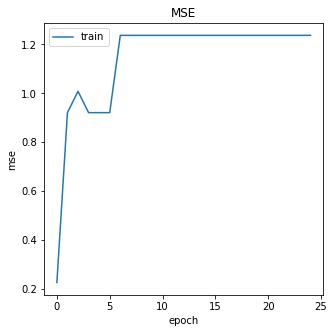

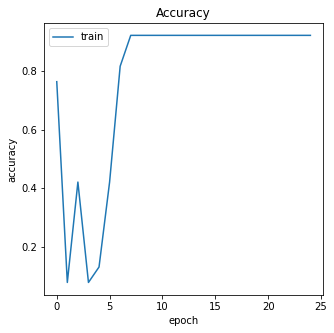

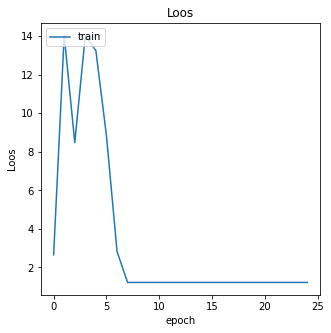

In [ ]:
plot_history(model_lstm, history_lstm)

In [ ]:
model_lstm.evaluate(x_train_lstm, y_train_lstm, verbose=2)

2/2 - 0s - loss: 1.2178 - mse: 1.2368 - accuracy: 0.9211


[1.217759132385254, 1.236842155456543, 0.9210526347160339]

In [ ]:
model_lstm.evaluate(x_test_lstm, y_test_lstm, verbose=2)

1/1 - 0s - loss: 5.9327 - mse: 2.1538 - accuracy: 0.6154


[5.932672500610352, 2.153846263885498, 0.6153846383094788]

In [ ]:
y_pred = model_lstm.predict(x_train_lstm)
y_pred = [1 if x>0.5 else 0 for x in y_pred]

In [ ]:
y_true = list(y_train_lstm.reshape((y_train_lstm.shape[0])))

print(y_pred)
print(y_true)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]


In [ ]:
y_pred = model_lstm.predict(x_test_lstm)
y_pred = [1 if x>0.5 else 0 for x in y_pred]

In [ ]:
y_true = list(y_test_lstm.reshape((y_test_lstm.shape[0])))

print(y_pred)
print(y_true)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[8, 0],
       [5, 0]])

## AutoEncoder

In [ ]:
def split_dataset_for_ae(dataset):

    # add anomaly weeks to test data
    test_indexes = list(dataset[dataset['label']==1]['week'].unique())

    # select remaning test indexes by random (test_indexes are blacklisted)
    choices = list(set(range(total_week_count)).difference(test_indexes))
    test_indexes.extend([random.choice(choices) for i in range(test_week_size - len(test_indexes))])
    print("Test indexes: ",test_indexes)

    # split dataset
    test_data = dataset.loc[dataset['week'].isin(test_indexes)]
    train_data = dataset.loc[~dataset['week'].isin(test_indexes)]

    return train_data, test_data

In [ ]:
train, test = split_dataset_for_ae(dataset)

Test indexes:  [12, 13, 17, 18, 20, 39, 42, 51, 34, 7, 50, 44, 47, 27]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_scaler = MinMaxScaler(feature_range=(0,1))
min_scaler.fit(train[['power_comsumption']].to_numpy())
train[['power_comsumption']] = min_scaler.transform(train[['power_comsumption']].to_numpy())
test[['power_comsumption']] = min_scaler.transform(test[['power_comsumption']].to_numpy())

In [ ]:
x_train_ae, y_train_ae = reshape(np.asarray(train))
x_train_ae = x_train_ae.reshape((x_train_ae.shape[0],1, x_train_ae.shape[1]))
y_train_ae = y_train_ae.reshape((y_train_ae.shape[0], 1))

print(x_train_ae.shape)
print(y_train_ae.shape)

x_test_ae, y_test_ae = reshape(np.asarray(test))
x_test_ae = x_test_ae.reshape((x_test_ae.shape[0],1, x_test_ae.shape[1]))
y_test_ae = y_test_ae.reshape((y_test_ae.shape[0], 1))
print(x_test_ae.shape)
print(y_test_ae.shape)

(37, 1, 672)
(37, 1)
(14, 1, 672)
(14, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


In [ ]:
# define model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
model_ae = Sequential()
model_ae.add(LSTM(400, activation='relu', input_shape=(1, x_train_ae.shape[2]), return_sequences=True))
model_ae.add(LSTM(200, activation='relu', return_sequences=False))
model_ae.add(RepeatVector(1))
model_ae.add(LSTM(200, activation='relu', return_sequences=True))
model_ae.add(LSTM(400, activation='relu', return_sequences=True))
model_ae.add(TimeDistributed(Dense(x_train_ae.shape[2])))
model_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 400)            1716800   
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               480800    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 200)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 200)            320800    
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 400)            961600    
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 672)            269472    
Total params: 3,749,472
Trainable params: 3,749,472
Non-trainable params: 0
____________________________________________

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model_ae.compile(optimizer=adam, loss='mse')

In [ ]:
history_ae = model_ae.fit(x_train_ae, x_train_ae, epochs=30)
print(history_ae.history.keys())

Epoch 1/30
2/2 [==============================] - 0s 17ms/step - loss: 0.1335
Epoch 2/30
2/2 [==============================] - 0s 16ms/step - loss: 0.1322
Epoch 3/30
2/2 [==============================] - 0s 17ms/step - loss: 0.1310
Epoch 4/30
2/2 [==============================] - 0s 16ms/step - loss: 0.1296
Epoch 5/30
2/2 [==============================] - 0s 18ms/step - loss: 0.1282
Epoch 6/30
2/2 [==============================] - 0s 16ms/step - loss: 0.1265
Epoch 7/30
2/2 [==============================] - 0s 16ms/step - loss: 0.1246
Epoch 8/30
2/2 [==============================] - 0s 16ms/step - loss: 0.1218
Epoch 9/30
2/2 [==============================] - 0s 17ms/step - loss: 0.1172
Epoch 10/30
2/2 [==============================] - 0s 16ms/step - loss: 0.1065
Epoch 11/30
2/2 [==============================] - 0s 18ms/step - loss: 0.0772
Epoch 12/30
2/2 [==============================] - 0s 17ms/step - loss: 0.0332
Epoch 13/30
2/2 [==============================] - 0s 17ms/st

In [ ]:
model_ae.evaluate(x_train_ae, x_train_ae, verbose=2)

2/2 - 0s - loss: 0.0019


0.001933043240569532

In [ ]:
model_ae.evaluate(x_test_ae, x_test_ae, verbose=2)

1/1 - 0s - loss: 0.0075


0.0074798790737986565

In [ ]:
def plot_prediction_of_ae(y_pred, y_true):
    plt.figure(figsize=(30,10))
    y_true = pd.DataFrame(data=np.asarray(y_true).flatten())
    y_pred = pd.DataFrame(data=np.asarray(y_pred).flatten())
    plt.plot(y_true, color='green', label="true")
    plt.plot(y_pred, color='red',label="prediction")
    plt.xlabel('cycles (in every 15 min)')
    plt.ylabel('power consumption')
    plt.legend(loc="upper left")
    plt.title("Week " + str(week))
    plt.show()

(37, 1, 672)


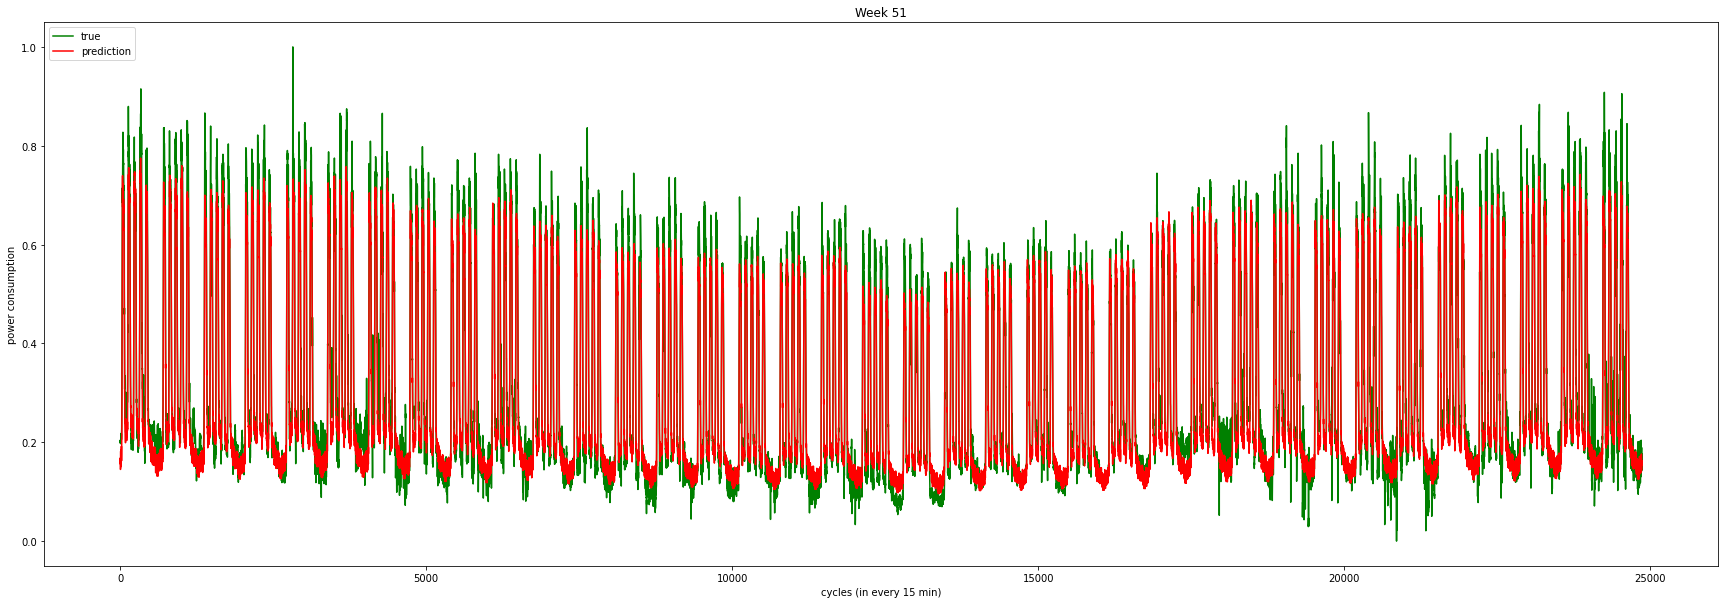

In [ ]:
y_pred_train = model_ae.predict(x_train_ae, verbose=0)
print(y_pred_train.shape)
y_pred_train = y_pred_train.reshape((y_pred_train.shape[0], y_pred_train.shape[2]))
y_true_train = x_train_ae.reshape((x_train_ae.shape[0], x_train_ae.shape[2]))

plot_prediction_of_ae(y_pred_train, y_true_train)

In [ ]:
y_pred = model_ae.predict(x_test_ae, verbose=0)
print(y_pred.shape)

(14, 1, 672)


In [ ]:
y_pred = y_pred.reshape((y_pred.shape[0], y_pred.shape[2]))
y_true = x_test_ae.reshape((x_test_ae.shape[0], x_test_ae.shape[2]))
print(y_pred.shape)
print(y_true.shape)

(14, 672)
(14, 672)


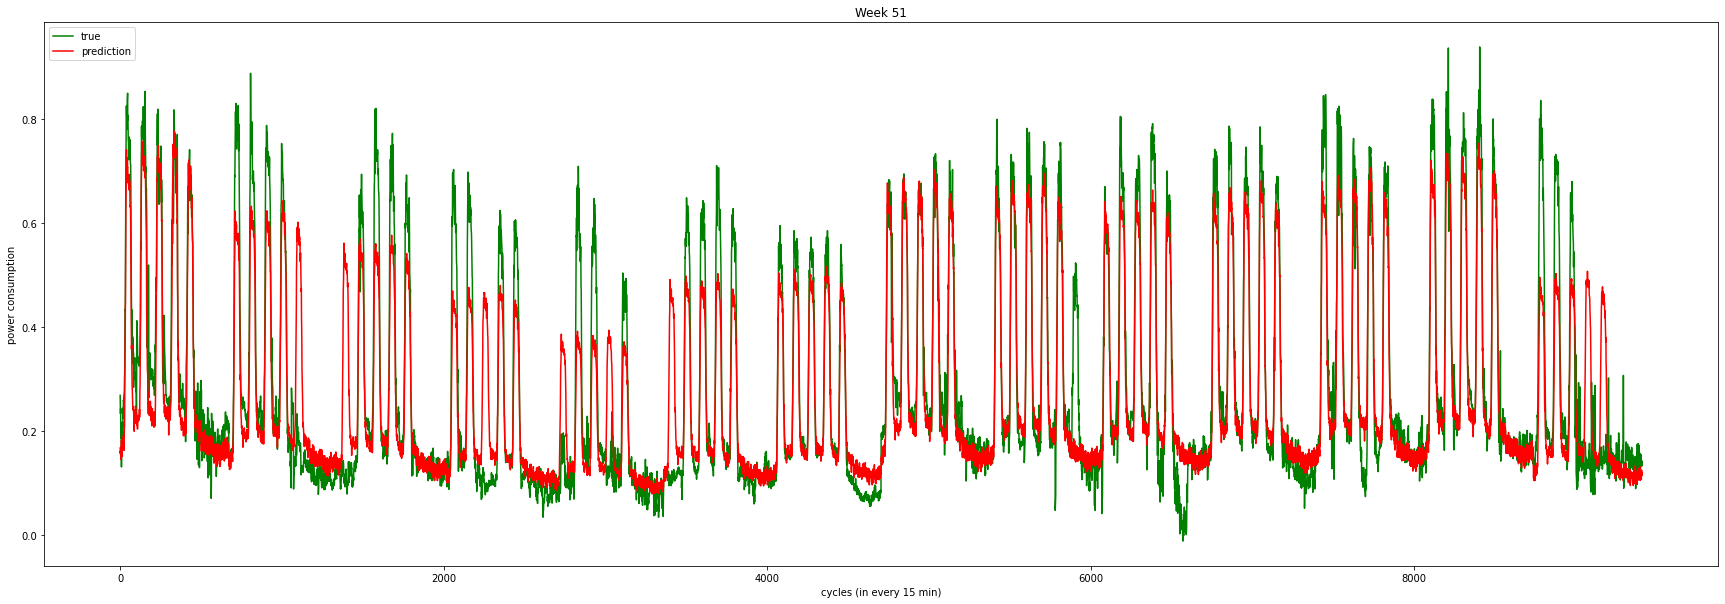

In [ ]:
plot_prediction_of_ae(y_pred, y_true)

In [ ]:
from sklearn.metrics import mean_squared_error
predicted_anomalies = []
for i in range(len(y_true)):
    mse = mean_squared_error(y_pred[i], y_true[i])
    if mse > 0.003:
        predicted_anomalies.append(1)
    else:
        predicted_anomalies.append(0)
print(predicted_anomalies)

[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1]


In [ ]:
y_true = list(y_test_ae.reshape((y_test_ae.shape[0])))
print(y_true)

[0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]


In [ ]:
error = np.mean(y_true != predicted_anomalies)

In [ ]:
print("Prediction result: %", error*100)

Prediction result: % 100.0
